In [36]:
%matplotlib inline
import os
import math
import collections
import torch
from torch import nn
from tqdm.notebook import tqdm
import funcs
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
from IPython.display import clear_output


backend_inline.set_matplotlib_formats('svg')

In [2]:
train_iter, src_vocab, tgt_vocab = funcs.load_data_nmt(batch_size=2, num_steps=8)

  0%|          | 0/11489286 [00:00<?, ?it/s]

# 序列到序列学习

机器翻译中的输入序列和输出序列都是长度可变的。 为了解决这类问题，使用通用的”编码器－解码器“架构。
<p style="text-indent: 2em;">遵循编码器－解码器架构的设计原则， 循环神经网络编码器使用长度可变的序列作为输入， 将其转换为固定形状的隐状态。 换言之，输入序列的信息被编码到循环神经网络编码器的隐状态中。 为了连续生成输出序列的词元， 独立的循环神经网络解码器是基于输入序列的编码信息 和输出序列已经看见的或者生成的词元来预测下一个词元。</p>
<p style="text-align: center;">
    <img src="./imgs/seq2seq.svg" style="background-color: white;">
</p>

## 编码器
<p style="text-indent: 2em;">
    编码器将长度可变的输入序列转换成 形状固定的上下文变量 c ， 并且将输入序列的信息在该上下文变量中进行编码。
    到目前为止，我们使用的是一个单向循环神经网络来设计编码器， 其中隐状态只依赖于输入子序列， 这个子序列是由输入序列的开始位置到隐状态所在的时间步的位置 （包括隐状态所在的时间步）组成。 我们也可以使用双向循环神经网络构造编码器， 其中隐状态依赖于两个输入子序列， 两个子序列是由隐状态所在的时间步的位置之前的序列和之后的序列 （包括隐状态所在的时间步）， 因此隐状态对整个序列的信息都进行了编码。
</p>

注意，我们使用了嵌入层（embedding layer） 来获得输入序列中每个词元的特征向量。 嵌入层的权重是一个矩阵， 其行数等于输入词表的大小（vocab_size）， 其列数等于特征向量的维度（embed_size）。 对于任意输入词元的索引$i$， 嵌入层获取权重矩阵的第$i$行（从0开始）以返回其特征向量。 另外，本文选择了一个多层门控循环单元来实现编码器。

In [3]:
class seq2SeqEncoder(funcs.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)
    
    def forward(self, X:torch.Tensor, *args):
        # 数据输入为 (batch, timestep)，embedding之后将时间序列放在前面
        X = self.embedding(X)
        X = X.permute(1, 0, 2) 
        output, state = self.rnn(X)
        # output的形状: (num_steps, batch_size, num_hiddens)
        # state的形状 : (num_layers,batch_size, num_hiddens)
        return output, state

In [71]:
encoder = seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)

output, state = encoder(X)
output.shape, state.shape

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

## 解码器
编码器输出的上下文变量 $c$ 对整个输入序列进行编码，来自训练数据集的输出序列 $y_1, y_2, ..., y_T$ , 对于每个时间步 $t'$ 解码器输出 $y_{t'}$ 的概率取决于先前的输出子序列 $y_1, ..., y_{t'-1}$和上下文变量 $c$

在获得解码器的隐状态之后，使用输出层和 softmax 操作来计算在时间步 $t'$ 时输出 $y_{t'}$ 的条件概率。

当实现解码器时， 直接使用编码器最后一个时间步的隐状态来初始化解码器的隐状态。 这就要求使用循环神经网络实现的编码器和解码器具有相同数量的层和隐藏单元。 为了进一步包含经过编码的输入序列的信息， 上下文变量在所有的时间步与解码器的输入进行拼接（concatenate）。 为了预测输出词元的概率分布， 在循环神经网络解码器的最后一层使用全连接层来变换隐状态。

In [4]:
class Seq2SeqDecoder(funcs.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size+num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]
    
    def forward(self, X, state):
        X:torch.Tensor = self.embedding(X)
        # 数据输入为 (batch, timestep)，embedding之后将时间序列放在前面
        X = X.permute(1, 0, 2)
        # 复制context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1,0,2)
        # output的形状:(batch_size, num_steps, vocab_size)
        # state的形状: (num_layers, batch_size,num_hiddens)
        return output, state

用与前面提到的编码器中相同的超参数来实例化解码器。 如我们所见，解码器的输出形状变为（批量大小，时间步数，词表大小）， 其中张量的最后一个维度存储预测的词元分布。

In [90]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))


<p style="text-align: center;">
上述循环神经网络“编码器－解码器”模型中的各层
</p>

<p style="text-align: center;">
<img src="./imgs/seq2seq-details.svg" style="background-color: white;">
</p>

## 损失函数

在每个时间步，解码器预测了输出词元的概率分布。 类似于语言模型，可以使用softmax来获得分布， 并通过计算交叉熵损失函数来进行优化。特定的填充词元被添加到序列的末尾， 因此不同长度的序列可以以相同形状的小批量加载。 但是，我们应该将填充词元的预测排除在损失函数的计算之外。

为此，我们可以使用下面的`sequence_mask`函数 通过零值化屏蔽不相关的项， 以便后面任何不相关预测的计算都是与零的乘积，结果都等于零。

在PyTorch中，符号`~`表示按位取反（bitwise NOT）的操作符。因此，`X[~mask]`将对张量`mask`中的每个元素执行按位取反操作，生成一个布尔张量（boolean tensor），然后将该布尔张量用作`X`张量的索引，从`X`张量中选择相应的元素。具体来说，如果`mask`张量的某个元素为0，则对应的`X`张量元素将被选择；如果`mask`张量的某个元素为非零值，则对应的`X`张量元素将被忽略。

In [6]:
def sequence_mask(X:torch.Tensor, valid_len, value=0):
    """屏蔽序列中的无关项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

In [7]:
X = torch.tensor([[1,2,3,4], [3,4,5,6]])
val_len = torch.tensor([3,2])
sequence_mask(X, val_len, 0)

tensor([[1, 2, 3, 0],
        [3, 4, 0, 0]])

可以通过扩展softmax交叉熵损失函数来遮蔽不相关的预测。 最初，所有预测词元的掩码都设置为1。 一旦给定了有效长度，与填充词元对应的掩码将被设置为0。 最后，将所有词元的损失乘以掩码，以过滤掉损失中填充词元产生的不相关预测。


In [8]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """
    输入参数
    ---------------
    `pred` : Tensor (batch_size, num_steps, vocab_size)
    `label`: Tensor (batch_size, num_steps)
    `valid_len`:Tensor (batch_size, )
    """
    def forward(self, pred:torch.Tensor, label:torch.Tensor, valid_len:torch.Tensor):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        # self.reduction='none' 使得CE损失计算后不进行平均化处理
        self.reduction='none'
        unweighted_loss:torch.Tensor = super().forward(
            pred.permute((0,2,1)), label
        )
        # 将无关项的损失变为0后再平均化
        weightsed_loss = (unweighted_loss * weights).mean(dim=1)
        return weightsed_loss

创建三个相同的序列来进行代码健全性检查， 然后分别指定这些序列的有效长度为 4, 2, 0。 结果就是，第一个序列的损失应为第二个序列的两倍，而第三个序列的损失应为零。

In [6]:
loss = MaskedSoftmaxCELoss()
loss(   torch.ones(3, 4, 10), 
        torch.ones((3, 4), dtype=torch.long),
        torch.tensor([4, 2, 0])
    )

tensor([2.3026, 1.1513, 0.0000])

## 训练
在下面的循环训练过程中，特定的序列开始词元（`<bos>`）和 原始的输出序列（不包括序列结束词元`<eos>`） 拼接在一起作为解码器的输入。 这被称为强制教学（teacher forcing）， 因为原始的输出序列（词元的标签）被送入解码器。 或者，将来自上一个时间步的预测得到的词元作为解码器的当前输入。

In [9]:
def train_seq2seq(net:funcs.EncoderDecoder, data_iter, lr, num_epo, tgt_vocab, device):
    """"""
    def xavier_init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
        if isinstance(m, nn.GRU):
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    
    l_list = []
    clear_output(wait=True)
    print("Training ... ")
    for epoch in tqdm(range(num_epo)):
        timer = funcs.Timer()
        metric = funcs.Accumulator(2)  # 损失，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = \
                [i.to(device) for i in batch]
            # 强制教学 ，在每个标签句子的开头添加 "<bos>" 符号
            bos =torch.tensor([tgt_vocab["<bos>"]] * Y.shape[0], device=device).reshape(-1,1)
            # 同时标签句子的尾端被去掉
            dec_input = torch.cat((bos, Y[:, :-1]), 1)
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            funcs.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        l_list.append(float(metric[0] / metric[1]))
        # if (epoch+1) % 10 == 0:
            # clear_output(wait=True)
            # print(f"epo:{epoch + 1}: avg_loss:{(metric[0] / metric[1],)}")
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
    f'tokens/sec on {str(device)}')
    return l_list
    

Training ... 


  0%|          | 0/300 [00:00<?, ?it/s]

loss 0.019, 35131.6 tokens/sec on cuda:0


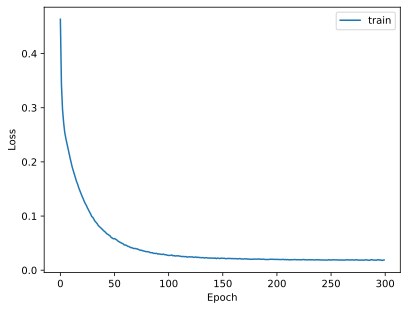

In [10]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, "cuda:0"

print("Loading dataset... ")
train_iter, src_vocab, tgt_vocab = funcs.load_data_nmt(batch_size, num_steps)
encoder = seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)

net = funcs.EncoderDecoder(encoder, decoder)
l_list = train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

plt.title("Seq2Seq Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss") 
plt.plot(l_list)
plt.legend(["train"])

## 预测
为了采用一个接着一个词元的方式预测输出序列， 每个解码器当前时间步的输入都将来自于前一时间步的预测词元。 与训练类似，序列开始词元（`<bos>`） 在初始时间步被输入到解码器中。 该预测过程如图所示， 当输出序列的预测遇到序列结束词元（`<eos>`）时，预测就结束了。
<p style="text-align: center;">
使用循环神经网络编码器-解码器逐词元地预测输出序列
</p>

<p style="text-align: center;">
<img src="./imgs/seq2seq-predict.svg" style="background-color: white;">
</p>

In [76]:
def predict_seq2seq(net:funcs.EncoderDecoder, src_sentence:str, src_vocab:funcs.Vocab, 
                    tgt_vocab:funcs.Vocab, max_steps:int, device:str, save_attention_weights=False):
    
    net.eval()
    src_sentence = "<bos> " + src_sentence if not src_sentence.startswith("<bos> ") else src_sentence
    src_sentence_tensor, _ = funcs.build_array_nmt([src_sentence.lower().split(" ")], src_vocab, max_steps)
    src_sentence_tensor = src_sentence_tensor.to(device)
    enc_output = net.encoder(src_sentence_tensor,)
    state      = net.decoder.init_state(enc_output)

    outputs   = [src_vocab["<bos>"]]
    # 每次以输出序列的最后一个字符作为输入
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1,1))
    attention_weight_seq = []
    # 这个阶段为预测阶段
    for _ in range(max_steps):
        y_hat, state = net.decoder.forward(get_input(), state)
        outputs.append(int(y_hat.argmax(dim=-1).reshape(1)))
        
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        
        if outputs[-1] == tgt_vocab["<eos>"]:
            outputs.pop()
            outputs.pop(0)
            break
    return ''.join([tgt_vocab.idx_to_token[i] + " " for i in outputs])[:-1], attention_weight_seq

In [77]:
predict_seq2seq(net, "i lost .", src_vocab, tgt_vocab, 15, device)[0]

"j'ai perdu ."

## 预测序列的评估
可以通过与真实的标签序列进行比较来评估预测序列。 虽然 (Papineni et al., 2002) 提出的`BLEU`（bilingual evaluation understudy） 最先是用于评估机器翻译的结果， 但现在它已经被广泛用于测量许多应用的输出序列的质量。 原则上说，对于预测序列中的任意 $n$ 元语法（n-grams）， BLEU的评估都是这个 $n$ 元语法是否出现在标签序列中。
BLUE定义为： 
$$
exp(min(0,1 - \frac{len_{label}}{len_{pred}})) \prod \limits_{n=1}^k p_{n}^{1/2^n}
$$ 
其中$len_{label}$表示标签序列中的词元数$len_{pred}$表示预测序列中的词元数,k是用于匹配的最长的n元语法。用$p_n$表示n元语法的精确度，它是两个数量的比值：
$$
p_n = \frac{预测序列与标签序列中匹配的n元语法的数量}{预测序列中n元语法的数量的比率。} 
$$
当预测序列与标签序列完全相同时，BLEU为1。此外，由于n元语法越长则匹配难度越大， 所以BLEU为更长的n元语法的精确度分配更大的权重。

In [52]:
def bleu(pred_seq:str, label_seq:str, k:float):
    '''
    计算BLEU
    `pred_seq`  : 预测的文本序列
    `label_seq` : 标签文本序列
    `k`         : 最大统计语法元数
    '''
    pred_tokens, label_tokens = pred_seq.split(" "),  label_seq.split(" ")
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label/len_pred))

    for n in range(1, k + 1):
        # 计算 n 元语法中的 P_n 值
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_pred - n + 1):
            # 在标签中取出所有的 n 元语法，并计数。
            label_subs[" ".join(label_tokens[i : i + n])] += 1
        for i in range(len_pred - n + 1):
            # 在预测值中寻找有没有匹配上的，包含匹配多次的情况
            if label_subs[" ".join(pred_tokens[i : i + n])] > 0:
                num_matches += 1
                # 匹配计数器，已经匹配过的计数减少
                label_subs[" ".join(pred_seq[i : i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1 + 1e-5), math.pow(0.5, n))
    return score

`defaultdic` 是 `dict` 的一个子类，它具有与 `dict` 类相同的所有方法，但是在以下方面有所不同：

1. 默认值： `defaultdict` 允许你指定一个默认值，这样当你访问字典中不存在的键时，它会返回这个默认值，而不是抛出 `KeyError` 异常。这个默认值可以是任何可调用对象，如 `int`、`list`、`lambda` 等。

2. 自动初始化：当你使用一个不存在的键来访问一个 `defaultdict` 时，它会自动初始化该键，并为它赋值为默认值。

In [69]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} \t=> {translation}\t bleu: {bleu(translation, fra, k=2):.3f}')

go . 	=> assieds-toi !	 bleu: 0.000
i lost . 	=> j'ai perdu .	 bleu: 1.000
he's calm . 	=> va doucement !	 bleu: 0.000
i'm home . 	=> je suis du <unk> !	 bleu: 0.447


## 小结
- 根据“编码器-解码器”架构的设计， 我们可以使用两个循环神经网络来设计一个序列到序列学习的模型。
- 我们可以使用遮蔽来过滤不相关的计算，例如在计算损失时。
- 在“编码器－解码器”训练中，强制教学方法将原始输出序列（而非预测结果）输入解码器。
- BLEU是一种常用的评估方法，它通过测量预测序列和标签序列之间的n元语法的匹配度来评估预测。